In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
clip_model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("clip.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)
    
    logits_per_image, logits_per_text = clip_model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

In [ ]:
!pip install -r requirements.txt
!pip install requests

In [ ]:
!wget https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip

In [ ]:
!mkdir images
!mv "/content/train.zip" "/content/images/"
!unzip /content/images/train.zip

In [6]:
!mv "/content/train" "/content/images/"
!rm /content/images/train.zip

In [ ]:
!wget https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip

In [ ]:
!mv "/content/val.zip" "/content/images/"
!unzip /content/images/val.zip

In [9]:
!mv "/content/val" "/content/images/"
!rm /content/images/val.zip

In [ ]:
!wget https://ivc.ischool.utexas.edu/VizWiz_final/images/test.zip

In [ ]:
!mv "/content/test.zip" "/content/images/"
!unzip /content/images/test.zip

In [12]:
!mv "/content/test" "/content/images/"
!rm /content/images/test.zip

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch.nn.functional as F
import numpy as np
import math

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        ''' Initialize the layers of this model.'''
        super().__init__()

        # Keep track of hidden_size for initialization of hidden state
        self.hidden_size = hidden_size

        # Embedding layer that turns words into a vector of a specified size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)

        # The LSTM takes embedded word vectors (of a specified size) as input
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(input_size=embed_size, \
                            hidden_size=hidden_size,  # LSTM hidden units
                            num_layers=1,  # number of LSTM layer
                            bias=True,  # use bias weights b_ih and b_hh
                            batch_first=True,  # input & output will have batch size as 1st dimension
                            dropout=0,  # Not applying dropout
                            bidirectional=False,  # unidirectional LSTM
                            )

        # The linear layer that maps the hidden state output dimension
        # to the number of words we want as output, vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)

        # initialize the hidden state
        # self.hidden = self.init_hidden()

    def init_hidden(self, batch_size):
        """ At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on previously seen data.
        So, this function defines a hidden state with all zeroes
        The axes semantics are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))

    def forward(self, features, captions):
        """ Define the feedforward behavior of the model """

        # Discard the <end> word to avoid predicting when <end> is the input of the RNN
        captions = captions[:, :-1]

        # Initialize the hidden state
        self.batch_size = features.shape[0]  # features is of shape (batch_size, embed_size)
        self.hidden = self.init_hidden(self.batch_size)
        
        # Create embedded word vectors for each word in the captions
        embeddings = self.word_embeddings(
            captions)  # embeddings new shape : (batch_size, captions length - 1, embed_size)

        # Stack the features and captions
        embeddings = torch.cat((features.unsqueeze(1), embeddings),
                               dim=1)  # embeddings new shape : (batch_size, caption length, embed_size)

        # Get the output and hidden state by passing the lstm over our word embeddings
        # the lstm takes in our embeddings and hidden state
        lstm_out, self.hidden = self.lstm(embeddings,
                                          self.hidden)  # lstm_out shape : (batch_size, caption length, hidden_size)

        # Fully connected layer
        outputs = self.linear(lstm_out)  # outputs shape : (batch_size, caption length, vocab_size)

        return outputs

    ## Greedy search
    def sample(self, inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "

        output = []
        batch_size = inputs.shape[0]  # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size)  # Get initial hidden state of the LSTM

        while True:
            lstm_out, hidden = self.lstm(inputs, hidden)  # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1)  # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1)  # predict the most likely next word, max_indice shape : (1)

            output.append(max_indice.cpu().numpy()[0].item())  # storing the word predicted

            if (max_indice == 1):
                # We predicted the <end> word, so there is no further prediction to do
                break

            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.word_embeddings(max_indice)  # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs shape : (1, 1, embed_size)

        return output

    ## Beam search implementation (Attempt)
    def beam_search_sample(self, inputs, beam=3):
        output = []
        batch_size = inputs.shape[0]  # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size)  # Get initial hidden state of the LSTM

        # sequences[0][0] : index of start word
        # sequences[0][1] : probability of the word predicted
        # sequences[0][2] : hidden state related of the last word
        sequences = [[[torch.Tensor([0])], 1.0, hidden]]
        max_len = 20

        ## Step 1
        # Predict the first word <start>
        outputs, hidden = DecoderRNN.get_outputs(self, inputs, hidden)
        _, max_indice = torch.max(outputs, dim=1)  # predict the most likely next word, max_indice shape : (1)
        output.append(max_indice.cpu().numpy()[0].item())  # storing the word predicted
        # inputs = DecoderRNN.get_next_word_input(self, max_indice)

        l = 0
        while len(sequences[0][0]) < max_len:
            print("l:", l)
            l += 1
            temp = []
            for seq in sequences:
                #                 print("seq[0]: ", seq[0])
                inputs = seq[0][-1]  # last word index in seq
                inputs = inputs.type(torch.cuda.LongTensor)
                print("inputs : ", inputs)
                # Embed the input word
                inputs = self.word_embeddings(inputs)  # inputs shape : (1, embed_size)
                inputs = inputs.unsqueeze(1)  # inputs shape : (1, 1, embed_size)

                # retrieve the hidden state
                hidden = seq[2]

                preds, hidden = DecoderRNN.get_outputs(self, inputs, hidden)

                # Getting the top <beam_index>(n) predictions
                softmax_score = F.log_softmax(outputs, dim=1)  # Define a function to sort the cumulative score
                sorted_score, indices = torch.sort(-softmax_score, dim=1)
                word_preds = indices[0][:beam]
                best_scores = sorted_score[0][:beam]

                # Creating a new list so as to put them via the model again
                for i, w in enumerate(word_preds):
                    #                     print("seq[0]: ", seq[0][0][:].cpu().numpy().item())
                    next_cap, prob = seq[0][0].cpu().numpy().tolist(), seq[1]

                    next_cap.append(w)
                    print("next_cap : ", next_cap)
                    prob * best_scores[i].cpu().item()
                    temp.append([next_cap, prob])

            sequences = temp
            # Order according to proba
            ordered = sorted(sequences, key=lambda tup: tup[1])

            # Getting the top words
            sequences = ordered[:beam]
            print("sequences: ", sequences)

    def get_outputs(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)  # lstm_out shape : (1, 1, hidden_size)
        outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
        outputs = outputs.squeeze(1)  # outputs shape : (1, vocab_size)

        return outputs, hidden

    def get_next_word_input(self, max_indice):
        ## Prepare to embed the last predicted word to be the new input of the lstm
        inputs = self.word_embeddings(max_indice)  # inputs shape : (1, embed_size)
        inputs = inputs.unsqueeze(1)  # inputs shape : (1, 1, embed_size)

        return inputs

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
from data_loader import get_loader
from torchvision import transforms
#Malikeh: from models import EncoderCNN, DecoderRNN
import math
import utils
import json

def validate(clip_model, decoder, criterion, data_loader, vocab_size, epoch, device='cpu', save_captions=False, linear_layer = None):
    with torch.no_grad():
        #Malikeh: encoder.eval()
        if linear_layer != None:
          linear_layer.eval()
        decoder.eval()
        val_loss = 0

        total_step = len(data_loader.dataset.paths) #number of images in val dataset
        predicted_captions = []
        print("Running Validation...")
        for batch in data_loader:
            # Obtain the batch.
            images, captions, img_id = batch #next(iter(data_loader))
            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)

            # Pass the inputs through the CNN-RNN model.
            features = clip_model.encode_image(images)
            if linear_layer != None:
                features = linear_layer(features)
            outputs = decoder(features, captions)

            # Calculate the batch loss.
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
            val_loss += loss

            if save_captions:
                pred = decoder.sample(features.unsqueeze(1))
                caption = utils.clean_sentence(pred, data_loader)
                predicted_captions.append({"image_id": int(img_id), "caption": str(caption)})

        if save_captions:
            with open('val_captions.json', 'w') as fp:
                json.dump(predicted_captions, fp)

        val_loss /= total_step
        print("Validation Loss for epoch " + str(epoch) + ': ' + str(float(val_loss)))
        return val_loss

In [ ]:
###Clip Without Linear Layer
import nltk
import torch
import torch.nn as nn
from torchvision import transforms
import sys
from data_loader import get_loader
import math
import ssl
import torch.utils.data as data
import numpy as np
import os
#Malikeh:from models import EncoderCNN, DecoderRNN
import utils
#Malikeh:import validation

if __name__ == "__main__":
    ssl._create_default_https_context = ssl._create_unverified_context
    nltk.download('punkt')

    batch_size = 32            # batch size
    vocab_threshold = 6        # minimum word count threshold
    vocab_from_file = False    # if True, load existing vocab file
    embed_size = 512           # dimensionality of image and word embeddings
    hidden_size = 512          # number of features in hidden state of the RNN decoder
    num_epochs = 1             # number of training epochs (1 for testing)
    save_every = 1             # determines frequency of saving model weights
    print_every = 200          # determines window for printing average loss
    log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

    transform_train = transforms.Compose([
        transforms.Resize(256),                          # smaller edge of image resized to 256
        transforms.RandomCrop(224),                      # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
        transforms.ToTensor(),                           # convert the PIL Image to a tensor
        transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                             (0.229, 0.224, 0.225))])

    # Build data loader.
    data_loader = get_loader(transform=transform_train, mode='train', batch_size=batch_size, vocab_threshold=vocab_threshold,
                             vocab_from_file=vocab_from_file)
    val_data_loader = get_loader(transform=transform_train, mode='val')

    # The size of the vocabulary.
    vocab_size = len(data_loader.dataset.vocab)
    print(vocab_size)

    # Initialize the encoder and decoder.
    #Malikeh:encoder = EncoderCNN(embed_size)
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    # Move models to GPU if CUDA is available.
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    #Malikeh:encoder.to(device)
    decoder.to(device)

    # Define the loss function.
    criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

    params = list(decoder.parameters()) #Malikeh + list(encoder.embed.parameters())

    optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    # optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
    #optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

    # Set the total number of training steps per epoch.
    total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
    #total_step = 1

    # Open the training log file.
    f = open(log_file, 'w')

    # Collect losses in these arrays
    training_loss_per_epoch = []
    val_loss_per_epoch = []

    for epoch in range(1, num_epochs + 1):
        avg_batch_loss = 0
        avg_training_loss = 0

        #Malikeh:encoder.train()
        decoder.train()

        for i_step in range(1, total_step + 1):

            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients.
            decoder.zero_grad()
            #Malikeh:encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            #Malikeh: features = encoder(images)
            with torch.no_grad():
              features = clip_model.encode_image(images)
            outputs = decoder(features, captions)

            # Calculate the batch loss.
            #         print("outputs.shape: ", outputs.shape)
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
            avg_batch_loss += loss
            avg_training_loss += loss

            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (
            epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)

        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
            #Malikeh:torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

        avg_batch_loss /= total_step
        training_loss_per_epoch.append(avg_batch_loss)

        
        print("\nTraining Loss for epoch " + str(epoch) + ': ' + str(float(avg_batch_loss)))
        val_loss = validate(clip_model, decoder, criterion, val_data_loader, vocab_size, epoch, device = device, save_captions=False, linear_layer = None)
        val_loss_per_epoch.append(val_loss)


    # Close the training log file.
    f.close()

    utils.plotLosses(training_loss_per_epoch,
                     val_loss_per_epoch,
                     'Cross Entropy Loss (per Epoch)')


    # test_data_loader = get_loader(transform=transform_train, mode='test')
    # test(clip_model, decoder, test_data_loader, device)

In [14]:
import torch
from torch import nn
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out.cuda().float())  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden.float())  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)).float()).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=768, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out.float())  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out.float())
        return h, c  

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [15]:
def get_clip_features(x):
  x1 = clip_model.visual.conv1(x.half()) #torch.Size([1, 768, 7, 7])
  x2 = x1.reshape(x1.shape[0], x1.shape[1], -1) #torch.Size([1, 768, 49])
  x3 = x2.permute(0, 2, 1) #torch.Size([1, 768, 49])
  x4 = torch.cat([clip_model.visual.class_embedding.to(x3.dtype) + torch.zeros(x3.shape[0], 1, x3.shape[-1], dtype=x3.dtype, device=x3.device), x3], dim=1)
  #torch.Size([1, 50, 768])
  x5 = x4 + clip_model.visual.positional_embedding.to(x4.dtype) #torch.Size([1, 50, 768])
  x6 = clip_model.visual.ln_pre(x5) #torch.Size([1, 50, 768])
  x7 = x6.permute(1, 0, 2)  # NLD -> LND #torch.Size([50, 1, 768])
  x8 = clip_model.visual.transformer(x7) #torch.Size([50, 1, 768])
  x9 = x8.permute(1, 0, 2)  # LND -> NLD torch.Size([1, 50, 768])
  return x9

In [16]:
import torch
import torch.nn as nn
import torch.utils.data as data
from data_loader import get_loader
from torchvision import transforms
#Malikeh: from models import EncoderCNN, DecoderRNN
import math
import utils
import json

def validate(clip_model, decoder, criterion, data_loader, vocab_size, epoch, device='cpu', save_captions=False, linear_layer = None):
    with torch.no_grad():
        #Malikeh: encoder.eval()
        if linear_layer != None:
          linear_layer.eval()
        decoder.eval()
        val_loss = 0

        total_step = len(data_loader.dataset.paths) #number of images in val dataset
        predicted_captions = []
        print("Running Validation...")
        for batch in data_loader:
            # Obtain the batch.
            images, captions, img_id = batch #next(iter(data_loader))
            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)

            # Pass the inputs through the CNN-RNN model.
            features = get_clip_features(images)
            if linear_layer != None:
                features = linear_layer(features)
            #outputs = decoder(features, captions)
            caplens = torch.tensor([captions.shape[1]]).reshape(1,1)
            caplens = caplens.to(device)

            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, captions, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = torch.nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = torch.nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True)


            # Calculate the batch loss.
            loss = criterion(scores.data, targets.data)
            #loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
            val_loss += loss

        val_loss /= total_step
        print("Validation Loss for epoch " + str(epoch) + ': ' + str(float(val_loss)))
        return val_loss

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created! imgs = 23431, anns = 100575
[0/100575] Tokenizing captions...
[100000/100575] Tokenizing captions...
loading annotations into memory...


  0%|          | 0/100575 [00:00<?, ?it/s]

Done (t=0.24s)
creating index...
index created! imgs = 23431, anns = 100575
Obtaining caption lengths...


100%|██████████| 100575/100575 [00:10<00:00, 9354.98it/s]


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.20s)
creating index...


  3%|▎         | 934/33145 [00:00<00:03, 9338.76it/s]

index created! imgs = 7750, anns = 33145
Obtaining caption lengths...


100%|██████████| 33145/33145 [00:03<00:00, 9450.70it/s]


Epoch [1/5], Step [200/3143], Loss: 4.7409
Epoch [1/5], Step [400/3143], Loss: 4.8517
Epoch [1/5], Step [600/3143], Loss: 4.7153
Epoch [1/5], Step [800/3143], Loss: 4.3040
Epoch [1/5], Step [1000/3143], Loss: 4.8538
Epoch [1/5], Step [1200/3143], Loss: 4.0638
Epoch [1/5], Step [1400/3143], Loss: 4.7034
Epoch [1/5], Step [1600/3143], Loss: 4.2157
Epoch [1/5], Step [1800/3143], Loss: 4.6249
Epoch [1/5], Step [2000/3143], Loss: 4.4693
Epoch [1/5], Step [2200/3143], Loss: 4.1417
Epoch [1/5], Step [2400/3143], Loss: 4.0952
Epoch [1/5], Step [2600/3143], Loss: 4.2739
Epoch [1/5], Step [2800/3143], Loss: 4.3693
Epoch [1/5], Step [3000/3143], Loss: 3.9678
Epoch [1/5], Step [3143/3143], Loss: 4.1132
Training Loss for epoch 1: 3.8724825382232666
Running Validation...
Validation Loss for epoch 1: 4.651616096496582
Epoch [2/5], Step [200/3143], Loss: 3.7792
Epoch [2/5], Step [400/3143], Loss: 4.0902
Epoch [2/5], Step [600/3143], Loss: 3.6627
Epoch [2/5], Step [800/3143], Loss: 3.7513
Epoch [2/5], 

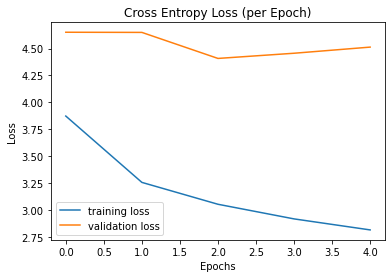

In [18]:
###Clip With Attention
import nltk
import torch
import torch.nn as nn
from torchvision import transforms
import sys
from data_loader import get_loader
import math
import ssl
import torch.utils.data as data
import numpy as np
import os
#Malikeh:from models import EncoderCNN, DecoderRNN
import utils
#Malikeh:import validation

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)
                

if __name__ == "__main__":
    ssl._create_default_https_context = ssl._create_unverified_context
    nltk.download('punkt')

    batch_size = 32            # batch size
    vocab_threshold = 6        # minimum word count threshold
    vocab_from_file = False    # if True, load existing vocab file
    embed_size = 512           # dimensionality of image and word embeddings
    hidden_size = 512          # number of image_features in hidden state of the RNN decoder
    num_epochs = 5             # number of training epochs (1 for testing)
    save_every = 1             # determines frequency of saving model weights
    print_every = 200          # determines window for printing average loss
    log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

    attention_dim = 512
    dropout = 0.5
    alpha_c = 1.
    encoder_dim=512
    grad_clip = 5.
    fine_tune_encoder = True

    transform_train = transforms.Compose([
        transforms.Resize(256),                          # smaller edge of image resized to 256
        transforms.RandomCrop(224),                      # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
        transforms.ToTensor(),                           # convert the PIL Image to a tensor
        transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                             (0.229, 0.224, 0.225))])

    # Build data loader.
    data_loader = get_loader(transform=transform_train, mode='train', batch_size=batch_size, vocab_threshold=vocab_threshold,
                             vocab_from_file=vocab_from_file)
    val_data_loader = get_loader(transform=transform_train, mode='val')

    # The size of the vocabulary.
    vocab_size = len(data_loader.dataset.vocab)

    # Initialize the encoder and decoder.
    # encoder = Encoder() #att-enc
    # encoder.fine_tune(fine_tune_encoder)
    #Malikeh: decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                   embed_dim=embed_size,
                                   decoder_dim=hidden_size,
                                   vocab_size=vocab_size,
                                   dropout=dropout)

    # Move models to GPU if CUDA is available.
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    #encoder.to(device) #att-enc
    decoder.to(device)

    # Define the loss function.
    criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

    params = list(decoder.parameters()) #+ list(encoder.parameters()) #att-enc

    #Malikeh: optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    # optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
    # optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

    # Set the total number of training steps per epoch.
    total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
    #total_step = 1

    # Open the training log file.
    f = open(log_file, 'w')

    # Collect losses in these arrays
    training_loss_per_epoch = []
    val_loss_per_epoch = []

    for epoch in range(1, num_epochs + 1):
        avg_batch_loss = 0

        #encoder.train() #att-enc
        decoder.train()

        for i_step in range(1, total_step + 1):

            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch.
            images, captions = next(iter(data_loader))
            

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients.
            decoder.zero_grad()
            # encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            # image_features = encoder(images)
            with torch.no_grad():
              image_features = get_clip_features(images)
              #image_features = clip_model.encode_image(images)
            #Malikeh: outputs = decoder(image_features, captions)
            caplens = [data_loader.dataset.caption_lengths[index] for index in indices] 
            caplens = torch.tensor(caplens).reshape(len(indices),1)
            caplens = caplens.to(device)

            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(image_features, captions, caplens)


            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = torch.nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = torch.nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate the batch loss.
            #         print("outputs.shape: ", outputs.shape)
 
            loss = criterion(scores.data, targets.data)
            
            avg_batch_loss += loss

            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Backward pass.
            loss.backward()

            clip_gradient(optimizer, grad_clip)
            

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (
            epoch, num_epochs, i_step, total_step, loss.item())

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)
            

        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
            #Malikeh:torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

        avg_batch_loss /= total_step
        training_loss_per_epoch.append(avg_batch_loss)

        
        print("\nTraining Loss for epoch " + str(epoch) + ': ' + str(float(avg_batch_loss)))
        val_loss = validate(clip_model, decoder, criterion, val_data_loader, vocab_size, epoch, device = device, save_captions=False, linear_layer = None)
        val_loss_per_epoch.append(val_loss)


    # Close the training log file.
    f.close()

    utils.plotLosses(training_loss_per_epoch,
                     val_loss_per_epoch,
                     'Cross Entropy Loss (per Epoch)')


    # test_data_loader = get_loader(transform=transform_train, mode='test')
    # test(clip_model, decoder, test_data_loader, device)